In [8]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [2]:
data_folder = 'data'
stocks = [ 'AMZN',  'NVDA']

stock_data = {}

for stock in stocks:
    file_name = f"{stock}_1d_arima.csv"
    file_path = os.path.join(data_folder, file_name)

    df = pd.read_csv(file_path)

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')

    df_stock = df.set_index('date')

    stock_data[stock] = df_stock
    print(f"{stock} data loaded, total: {len(df)} rows")

AMZN data loaded, total: 6976 rows
NVDA data loaded, total: 6551 rows


In [3]:
log_diff_data = {}
train_val_data = {}

for stock, df in stock_data.items():
    close_log = np.log(df['close'].dropna())
    close_log_diff = close_log.diff().dropna()

    train_size = int(len(close_log_diff) * 0.9)
    train_data = close_log_diff.iloc[:train_size]
    val_data = close_log_diff.iloc[train_size:]

    log_diff_data[stock] = (close_log, close_log_diff)
    train_val_data[stock] = (train_data, val_data)

In [ ]:
forecast_results = {}

for stock, (train_data, val_data) in train_val_data.items():
    history = list(train_data.values)
    predictions = []
    for actual in val_data:
        model = ARIMA(history, order=(1, 0, 1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)
        predictions.append(forecast.iloc[0])
        history.append(actual)

    forecast_results[stock] = pd.Series(predictions, index=val_data.index)

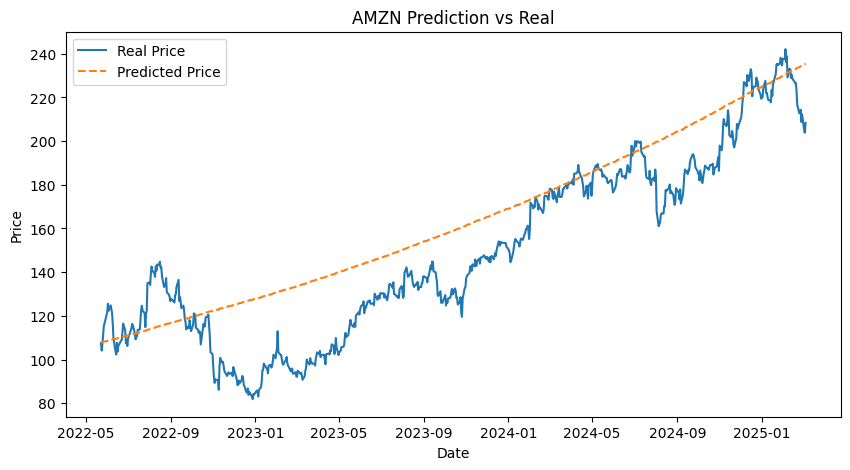

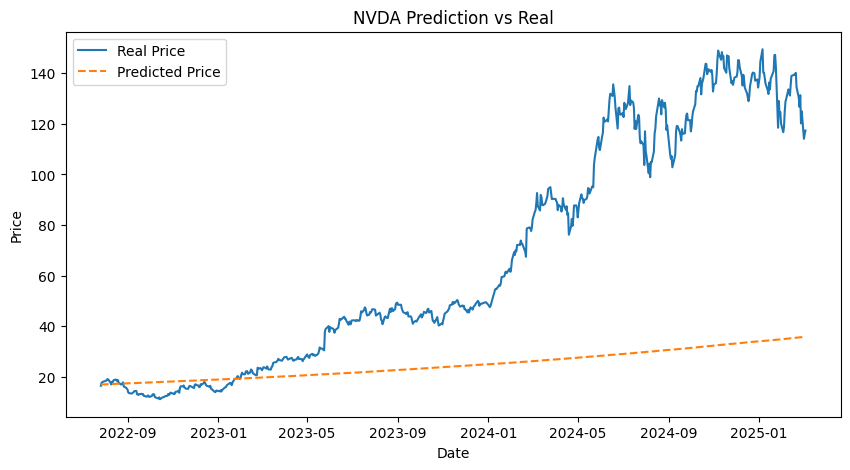

In [6]:
final_predictions = {}

for stock, forecast_diff in forecast_results.items():
    close_log, _ = log_diff_data[stock]
    train_data, val_data = train_val_data[stock]

    last_log = close_log.loc[train_data.index[-1]]
    forecast_log = last_log + forecast_diff.cumsum()
    forecast_price = np.exp(forecast_log)
    final_predictions[stock] = forecast_price

    actual_price = stock_data[stock]['close'].loc[forecast_price.index[0]:]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_price, label='Real Price')
    plt.plot(forecast_price, label='Predicted Price', linestyle='--')
    plt.title(f"{stock} Prediction vs Real")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [9]:

f1_results = {}

for stock, forecast_price in final_predictions.items():
    actual_price = stock_data[stock]['close'].loc[forecast_price.index]

    actual_trend = (actual_price.diff() > 0).astype(int).dropna()
    predicted_trend = (forecast_price.diff() > 0).astype(int).dropna()

    actual_trend, predicted_trend = actual_trend.align(predicted_trend, join='inner')

    f1 = f1_score(actual_trend, predicted_trend)
    f1_results[stock] = f1

    print(f"{stock} F1 Score: {f1:.4f}")


AMZN F1 Score: 0.6831
NVDA F1 Score: 0.7101
